<h2> Table of content </h2>
<ul> <li> <a href="#preparation"> Preparation </a> </li>
    <li> <a href="#load_data"> Load The Datas </a> </li>
    <li> <a href="#first_look"> First Look at The Data </a> </li>
    <li> <a href="#eda"> Explorations Data analysis </a> </li>
    <li> <a href="missing_values"> Missing Values </a> </li> 
    <li> <a href="feature_engineering"> Feature engineering </a> </li>
    <li> <a href="feat_exploration"> Features dataset explorations </a> </li>
    <li> <a href="modeling"> Modeling </a> </li>
    <li> <a href="submission"> Submission </a> </li>
</ul>
<hr>

<h2 id=preparation> Preparation </h2>

In [3]:

import numpy as np
import pandas as pd
import yfinance as yf  # Yahoo Finance for downloading stock data
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import lightgbm as lgbm
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import pickle
from tqdm import tqdm
import gc

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuration
TICKER = "SPY"  # S&P 500 ETF - can be changed to any stock/index
START_DATE = "2015-01-01"
END_DATE = datetime.now().strftime("%Y-%m-%d")
HOLD_DAYS = 5
VOL_TARGET = 0.10  # 10% annualized volatility target
SIGNAL_THRESHOLD = 0.60  # 60% probability threshold



<h2 id=load_data> Load The Datas

In [4]:
# Load OHLCV data from Yahoo Finance
print(f"Downloading {TICKER} data from {START_DATE} to {END_DATE}...")
ticker = yf.Ticker(TICKER)
ohlcv = ticker.history(start=START_DATE, end=END_DATE, interval="1d")
ohlcv.columns = [col.lower() for col in ohlcv.columns]

# Reset index to make date a column
ohlcv = ohlcv.reset_index()
if 'Date' in ohlcv.columns:
    ohlcv['date'] = pd.to_datetime(ohlcv['Date'])
    ohlcv = ohlcv.drop('Date', axis=1)
elif ohlcv.index.name == 'Date' or isinstance(ohlcv.index, pd.DatetimeIndex):
    ohlcv.index.name = 'date'
    ohlcv = ohlcv.reset_index()
    ohlcv['date'] = pd.to_datetime(ohlcv['date'])

ohlcv = ohlcv.set_index('date').sort_index()

print(f"Loaded {len(ohlcv)} days of data")
print(f"Date range: {ohlcv.index[0]} to {ohlcv.index[-1]}")
print(f"\nFirst few rows:")
print(ohlcv.head())
print(f"\nData shape: {ohlcv.shape}")
print(f"\nMissing values:")
print(ohlcv.isnull().sum())


Loaded 2730 days of data
Date range: 2015-01-02 00:00:00-05:00 to 2025-11-07 00:00:00-05:00

First few rows:
                                 open        high         low       close  \
date                                                                        
2015-01-02 00:00:00-05:00  171.884928  172.301356  170.052634  171.093704   
2015-01-05 00:00:00-05:00  170.044326  170.210895  167.695677  168.003830   
2015-01-06 00:00:00-05:00  168.311931  168.836634  165.621809  166.421356   
2015-01-07 00:00:00-05:00  167.753937  168.836652  167.304200  168.495178   
2015-01-08 00:00:00-05:00  169.910994  171.701643  169.894346  171.485092   

                              volume  dividends  stock splits  capital gains  
date                                                                          
2015-01-02 00:00:00-05:00  121465900        0.0           0.0            0.0  
2015-01-05 00:00:00-05:00  169632600        0.0           0.0            0.0  
2015-01-06 00:00:00-05:00  20915140

<a id="technical-indicators"></a>
## 2. Technical Indicators


In [19]:
def calculate_technical_indicators(df):
    """
    High-quality technical indicator block for ML:
    - Returns (simple & log)
    - RSI
    - Bollinger Bands
    - Momentum + Rate of Change
    - SMAs / EMAs
    - MACD
    - Trend & Regime Indicators
    - Volatility Indicators (ATR, realized vol)
    - Volume Indicators
    - High-Low & candle structure
    """
    data = df.copy()

    # ---------------------
    # BASIC RETURNS
    # ---------------------
    data['returns'] = data['close'].pct_change()
    data['log_returns'] = np.log(data['close'] / data['close'].shift(1))

    # ---------------------
    # RSI
    # ---------------------
    delta = data['close'].diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = (-delta.clip(upper=0)).rolling(14).mean()
    rs = gain / loss.replace(0, np.nan)
    data['rsi'] = 100 - (100 / (1 + rs))

    # ---------------------
    # BOLLINGER BANDS
    # ---------------------
    mb = data['close'].rolling(20).mean()
    ub = mb + 2 * data['close'].rolling(20).std()
    lb = mb - 2 * data['close'].rolling(20).std()
    data['bb_middle'] = mb
    data['bb_upper'] = ub
    data['bb_lower'] = lb
    data['bb_width'] = (ub - lb) / mb
    data['bb_position'] = (data['close'] - lb) / (ub - lb)

    # ---------------------
    # MOMENTUM
    # ---------------------
    data['momentum_5'] = data['close'].pct_change(5)
    data['momentum_10'] = data['close'].pct_change(10)
    data['momentum_20'] = data['close'].pct_change(20)
    data['roc_10'] = data['close'].pct_change(10)

    # ---------------------
    # MOVING AVERAGES (Fast/Slow trends)
    # ---------------------
    for w in [5, 10, 20, 50, 200]:
        data[f'sma_{w}'] = data['close'].rolling(w).mean()

    data['ema_12'] = data['close'].ewm(span=12, adjust=False).mean()
    data['ema_26'] = data['close'].ewm(span=26, adjust=False).mean()

    # MACD
    data['macd'] = data['ema_12'] - data['ema_26']
    data['macd_signal'] = data['macd'].ewm(span=9, adjust=False).mean()
    data['macd_hist'] = data['macd'] - data['macd_signal']

    # ---------------------
    # MOVING AVERAGE CROSSOVERS
    # ---------------------
    data['sma_cross_5_20'] = (data['sma_5'] > data['sma_20']).astype(int)
    data['sma_cross_20_50'] = (data['sma_20'] > data['sma_50']).astype(int)
    data['trend_regime'] = (data['sma_20'] > data['sma_50']).astype(int)

    # ---------------------
    # PRICE TO MA RATIOS
    # ---------------------
    data['price_to_sma20'] = data['close'] / data['sma_20'] - 1
    data['price_to_sma50'] = data['close'] / data['sma_50'] - 1

    # ---------------------
    # VOLUME FEATURES
    # ---------------------
    data['vol_sma20'] = data['volume'].rolling(20).mean()
    data['volume_ratio'] = data['volume'] / data['vol_sma20']
    data['volume_price_trend'] = (data['volume'] * data['returns']).rolling(20).sum()

    # ---------------------
    # VOLATILITY (ATR + Realized)
    # ---------------------
    hl = data['high'] - data['low']
    hc = (data['high'] - data['close'].shift()).abs()
    lc = (data['low'] - data['close'].shift()).abs()
    tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
    data['atr'] = tr.rolling(14).mean()
    data['atr_pct'] = data['atr'] / data['close']

    # Realized vol (annualized)
    for w in [5, 10, 20, 60]:
        data[f'realized_vol_{w}'] = data['returns'].rolling(w).std() * np.sqrt(252)

    # ---------------------
    # HIGH-LOW STRUCTURE
    # ---------------------
    data['hl_range'] = (data['high'] - data['low']) / data['close']
    data['hl_range_5'] = data['hl_range'].rolling(5).mean()

    # ---------------------
    # CANDLE STRUCTURE
    # ---------------------
    data['body'] = data['close'] - data['open']
    data['upper_shadow'] = data['high'] - data[['close', 'open']].max(axis=1)
    data['lower_shadow'] = data[['close', 'open']].min(axis=1) - data['low']
    data['strong_bull_candle'] = (data['body'] > data['body'].rolling(20).mean()).astype(int)
    data['strong_bear_candle'] = (data['body'] < -data['body'].rolling(20).mean()).astype(int)

    return data


print("✅ Calculating technical indicators...")
ohlcv = calculate_technical_indicators(ohlcv)
print(f"✅ Total features after technical indicators: {len(ohlcv.columns)}")


✅ Calculating technical indicators...
✅ Total features after technical indicators: 72


<a id="options-features"></a>
## 3. Options-Based Features

Note: Yahoo Finance has limited options data availability. We'll:
1. Try to get real options data where available
2. Use proxy measures based on realized volatility and market data
3. Simulate options-based features using historical patterns


In [20]:
import yfinance as yf
import numpy as np
import pandas as pd
from tqdm import tqdm

# ------------------------------
# 1. FETCH FULL OPTIONS CHAIN
# ------------------------------
def get_options_chain(ticker):
    """
    Download all available option expiries for a ticker from Yahoo Finance.
    Returns a single DataFrame containing calls + puts.
    """
    tk = yf.Ticker(ticker)
    expiries = tk.options

    if len(expiries) == 0:
        raise ValueError(f"No options expiries found for {ticker}")

    all_options = []

    for exp in expiries:
        try:
            chain = tk.option_chain(exp)
            calls = chain.calls.copy()
            calls["type"] = "call"
            calls["expiry"] = pd.to_datetime(exp)

            puts = chain.puts.copy()
            puts["type"] = "put"
            puts["expiry"] = pd.to_datetime(exp)

            all_options.append(calls)
            all_options.append(puts)
        except Exception as e:
            print(f"⚠️ Could not download expiry {exp}: {e}")
            continue

    df = pd.concat(all_options, ignore_index=True)
    df["expiry"] = pd.to_datetime(df["expiry"])
    return df


# ------------------------------
# 2. EXTRACT FEATURES FROM CHAIN
# ------------------------------
def extract_options_features(chain_df, spot_price):
    """
    Extract usable options features from the chain:
    - ATM IV
    - 25-delta IV skew (approx)
    - Put/Call Volume ratio
    - Put/Call OI ratio
    - Gamma Exposure (GEX)
    """
    df = chain_df.copy()

    # Use nearest expiry (highest liquidity)
    nearest_expiry = df["expiry"].min()
    df = df[df["expiry"] == nearest_expiry]

    if len(df) < 10:
        return None

    # ------------------------------
    # ATM IV
    # ------------------------------
    df["strike_diff"] = abs(df["strike"] - spot_price)
    atm_idx = df["strike_diff"].idxmin()
    atm_iv = df.loc[atm_idx, "impliedVolatility"]

    # ------------------------------
    # 25-Delta IV (approx proxy)
    # Take 5% highest/lowest strike options
    # ------------------------------
    calls = df[df["type"] == "call"].sort_values("strike")
    puts = df[df["type"] == "put"].sort_values("strike")

    if len(calls) < 5 or len(puts) < 5:
        call_25d_iv = np.nan
        put_25d_iv = np.nan
    else:
        call_25d_iv = calls.iloc[int(len(calls) * 0.05)]["impliedVolatility"]
        put_25d_iv = puts.iloc[int(len(puts) * 0.95)]["impliedVolatility"]

    iv_skew = put_25d_iv - call_25d_iv if not np.isnan(call_25d_iv) else np.nan

    # ------------------------------
    # Put/Call Ratios
    # ------------------------------
    total_call_vol = calls["volume"].sum()
    total_put_vol = puts["volume"].sum()

    pcr_volume = total_put_vol / (total_call_vol + 1)

    total_call_oi = calls["openInterest"].sum()
    total_put_oi = puts["openInterest"].sum()

    pcr_oi = total_put_oi / (total_call_oi + 1)

    # ------------------------------
    # Gamma Exposure (GEX)
    # GEX = Σ (Gamma * OI * contract_multiplier * spot_price)
    # ------------------------------
    if "gamma" in df.columns:
        df["gex_component"] = df["gamma"] * df["openInterest"] * 100 * spot_price
        gex = df["gex_component"].sum()
    else:
        gex = np.nan

    return {
        "atm_iv": atm_iv,
        "iv_skew": iv_skew,
        "pcr_volume": pcr_volume,
        "pcr_oi": pcr_oi,
        "gex": gex,
        "nearest_expiry": nearest_expiry
    }


# ------------------------------
# 3. BUILD DAILY OPTIONS FEATURES
# ------------------------------
def calculate_options_features(ohlcv, ticker):
    """
    For each OHLCV date, compute options features.
    Since Yahoo only provides CURRENT chain, we treat it as regime proxy.
    """
    print("📈 Fetching full options chain once...")
    chain = get_options_chain(ticker)

    rows = []

    print("📘 Calculating daily options features...")
    for date, row in tqdm(ohlcv.iterrows(), total=len(ohlcv)):
        spot = row["close"]
        feats = extract_options_features(chain, spot)

        if feats is None:
            continue

        feats["date"] = date
        rows.append(feats)

    opt_df = pd.DataFrame(rows).set_index("date")

    # Add IV percentile
    opt_df["iv_percentile"] = opt_df["atm_iv"].rank(pct=True)

    # Term structure proxy (ATM IV vs 5-day realized vol)
    opt_df["iv_term_structure"] = opt_df["atm_iv"] - ohlcv["realized_vol_5"]

    return opt_df


print("✅ Calculating REAL options-based features...")
options_df = calculate_options_features(ohlcv, TICKER)

print("✅ Merging options features with OHLCV...")
ohlcv = ohlcv.merge(options_df, left_index=True, right_index=True, how="left")

print("✅ Options features added:", len(options_df.columns))
print(options_df.tail())


✅ Calculating REAL options-based features...
📈 Fetching full options chain once...
📘 Calculating daily options features...


100%|██████████| 2721/2721 [00:03<00:00, 805.32it/s]

✅ Merging options features with OHLCV...
✅ Options features added: 8
                             atm_iv   iv_skew  pcr_volume    pcr_oi  gex  \
date                                                                       
2025-10-27 00:00:00-04:00  0.107431 -0.108886    1.015453  0.878374  NaN   
2025-10-28 00:00:00-04:00  0.115243 -0.108886    1.015453  0.878374  NaN   
2025-10-29 00:00:00-04:00  0.115243 -0.108886    1.015453  0.878374  NaN   
2025-10-30 00:00:00-04:00  0.106698 -0.108886    1.015453  0.878374  NaN   
2025-10-31 00:00:00-04:00  0.105966 -0.108886    1.015453  0.878374  NaN   

                          nearest_expiry  iv_percentile  iv_term_structure  
date                                                                        
2025-10-27 00:00:00-04:00     2025-11-10       0.001103           0.000180  
2025-10-28 00:00:00-04:00     2025-11-10       0.002021           0.012945  
2025-10-29 00:00:00-04:00     2025-11-10       0.002021           0.044338  
2025-10-30 00

<a id="label-creation"></a>
## 4. Label Creation

Create binary labels based on 5-day forward volatility-adjusted returns:
- Forward 5-day return / Forward 5-day realized volatility
- Label = 1 if adjusted return > 0, else 0


In [21]:
def create_labels(df, hold_days=5, winsorize_limit=5):
    """
    Create high-quality labels for supervised ML in trading:
    - Forward return over hold_days
    - Forward realized volatility using future returns
    - Volatility-adjusted return (Sharpe-like)
    - Binary label = 1 if vol-adjusted return > 0
    """
    data = df.copy()

    # -------------------------------
    # 1. Forward return
    # -------------------------------
    data['forward_return'] = data['close'].shift(-hold_days) / data['close'] - 1

    # -------------------------------
    # 2. Future returns for volatility
    # -------------------------------
    future_returns = data['returns'].shift(-1)

    # compute rolling std of future returns
    forward_vol = (
        future_returns
        .rolling(hold_days)
        .std() * np.sqrt(252)
    )

    data['forward_realized_vol'] = forward_vol.shift(-(hold_days - 1))

    # -------------------------------
    # 3. Vol-adjusted return
    # -------------------------------
    data['vol_adjusted_return'] = (
        data['forward_return'] 
        / (data['forward_realized_vol'] + 1e-8)
    )

    # Winsorize volatility-adjusted return (remove extreme noise)
    data['vol_adjusted_return'] = data['vol_adjusted_return'].clip(
        lower=-winsorize_limit,
        upper=winsorize_limit
    )

    # -------------------------------
    # 4. Binary label
    # -------------------------------
    data['label'] = (data['vol_adjusted_return'] > 0).astype(int)

    return data

# Create labels
print("✅ Creating high-quality labels...")
ohlcv = create_labels(ohlcv, hold_days=HOLD_DAYS)

# Remove last few NaN rows
ohlcv = ohlcv.dropna(subset=['label'])

print("\n✅ Label distribution:")
print(ohlcv['label'].value_counts())
print("\n✅ Volatility-adjusted return stats:")
print(ohlcv['vol_adjusted_return'].describe())
print("\n✅ Data shape:", ohlcv.shape)


✅ Creating high-quality labels...

✅ Label distribution:
label
1    1679
0    1042
Name: count, dtype: int64

✅ Volatility-adjusted return stats:
count    2716.000000
mean        0.053688
std         0.181412
min        -0.961958
25%        -0.053665
50%         0.047216
75%         0.154028
max         1.747540
Name: vol_adjusted_return, dtype: float64

✅ Data shape: (2721, 80)


<a id="model-training"></a>
## 5. Model Training

Train LightGBM classifier with:
- Class imbalance handling (splitting negative samples into 3 severity classes)
- Time-series cross-validation
- Feature importance analysis


In [27]:
print("✅ Preparing feature set...")

# ---------------------------------------------------------
# 1. Convert 'nearest_expiry' to numeric days-to-expiry (timezone-safe)
# ---------------------------------------------------------
if "nearest_expiry" in ohlcv.columns:
    idx = pd.to_datetime(ohlcv.index).tz_localize(None)
    exp = ohlcv["nearest_expiry"].dt.tz_localize(None)
    ohlcv["days_to_expiry"] = (exp - idx).dt.days
else:
    ohlcv["days_to_expiry"] = np.nan

# ---------------------------------------------------------
# 2. Columns to EXCLUDE (includes label_severity)
# ---------------------------------------------------------
exclude_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'dividends', 'stock splits',
    'forward_return', 'forward_realized_vol',
    'vol_adjusted_return', 'label', 'returns', 'log_returns',
    'nearest_expiry',
    'label_severity'        # ✅ CRITICAL: remove leakage
]

# ---------------------------------------------------------
# 3. Build initial feature list
# ---------------------------------------------------------
feature_cols = [col for col in ohlcv.columns if col not in exclude_cols]

# ---------------------------------------------------------
# 4. Drop columns where more than 95% are NaN
# ---------------------------------------------------------
feature_cols = [
    col for col in feature_cols
    if ohlcv[col].notna().mean() > 0.05
]

# ---------------------------------------------------------
# 5. Identify feature categories (for logging)
# ---------------------------------------------------------
tech_features = [col for col in feature_cols if any(x in col for x in [
    'rsi', 'bb_', 'momentum', 'sma', 'ema', 'macd',
    'atr', 'realized_vol', 'volume', 'hl_range', 'body'
])]

options_features = [col for col in feature_cols if any(x in col for x in [
    'iv', 'pcr', 'gex', 'vix', 'days_to_expiry'
])]

print(f"✅ Total features selected: {len(feature_cols)}")
print(f"   - Technical features: {len(tech_features)}")
print(f"   - Options features:   {len(options_features)}")

# ---------------------------------------------------------
# 6. Prepare final dataset
# ---------------------------------------------------------
X = ohlcv[feature_cols].ffill().fillna(0)
y = ohlcv['label']

valid_mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[valid_mask]
y = y[valid_mask]

print("\n✅ Final dataset shapes:")
print(f"   X: {X.shape}")
print(f"   y: {y.shape}")
print(f"✅ Label distribution: {y.value_counts().to_dict()}")
print(f"✅ Positive class %: {y.mean():.3f}")


✅ Preparing feature set...
✅ Total features selected: 65
   - Technical features: 40
   - Options features:   17

✅ Final dataset shapes:
   X: (2721, 65)
   y: (2721,)
✅ Label distribution: {1: 1679, 0: 1042}
✅ Positive class %: 0.617


In [39]:
print("✅ Preparing train/test split (time-series safe)...")

# ---------------------------------------------------------
# 1. Time-based split (80% train, 20% test)
# ---------------------------------------------------------
split_index = int(len(X) * 0.8)
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

print(f"Train period: {X_train.index[0]} → {X_train.index[-1]}")
print(f"Test period:  {X_test.index[0]} → {X_test.index[-1]}")
print()

print("Train label distribution:", y_train.value_counts().to_dict())
print("Test label distribution:", y_test.value_counts().to_dict())
print()

# ---------------------------------------------------------
# 2. Compute class weight for imbalance
# ---------------------------------------------------------
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

print(f"Class imbalance → scale_pos_weight = {scale_pos_weight:.2f}")

# Store for LightGBM training
class_weight_params = {
    "is_unbalance": False,
    "scale_pos_weight": scale_pos_weight
}
# ---------------------------------------------------------
# ✅ Save features used during training
# ---------------------------------------------------------
training_feature_cols = list(X_train.columns)
print(f"✅ Saved {len(training_feature_cols)} training features.")


✅ Preparing train/test split (time-series safe)...
Train period: 2015-01-08 00:00:00-05:00 → 2023-08-30 00:00:00-04:00
Test period:  2023-08-31 00:00:00-04:00 → 2025-10-31 00:00:00-04:00

Train label distribution: {1: 1331, 0: 845}
Test label distribution: {1: 348, 0: 197}

Class imbalance → scale_pos_weight = 0.63
✅ Saved 65 training features.


In [40]:
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np

print("✅ Starting LightGBM Training (Time-Series Safe)...")

# =========================================================
# ✅ 1. Save the list of training features (MOST IMPORTANT)
# =========================================================
training_feature_cols = list(X_train.columns)
print(f"✅ Saved {len(training_feature_cols)} training features.")

# =========================================================
# ✅ 2. Time-Series Cross Validation
# =========================================================
tscv = TimeSeriesSplit(n_splits=5)

fold_models = []
fold_aucs = []

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 80,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
    'is_unbalance': False,
    'scale_pos_weight': class_weight_params['scale_pos_weight']
}

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"\n✅ Training Fold {fold+1}...")

    X_tr = X_train.iloc[train_idx]
    y_tr = y_train.iloc[train_idx]
    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    train_set = lgb.Dataset(X_tr, label=y_tr)
    val_set = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(
        params,
        train_set,
        num_boost_round=2000,
        valid_sets=[train_set, val_set],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ]
    )

    fold_models.append(model)

    preds_val = model.predict(X_val)
    auc_val = roc_auc_score(y_val, preds_val)
    fold_aucs.append(auc_val)

    print(f"✅ Fold {fold+1} AUC: {auc_val:.4f}")

print("\n===================================")
print("✅ Cross-validated AUC Scores:")
for i, auc in enumerate(fold_aucs):
    print(f"   Fold {i+1}: {auc:.4f}")
print(f"\n✅ Mean AUC = {np.mean(fold_aucs):.4f}")
print("===================================\n")

# =========================================================
# ✅ 3. Final Ensemble Evaluation on Test Set
# =========================================================
print("✅ Evaluating Ensemble on Test Set...")

test_preds = np.mean([m.predict(X_test) for m in fold_models], axis=0)
test_auc = roc_auc_score(y_test, test_preds)

print(f"✅ Test AUC: {test_auc:.4f}")

y_pred_binary = (test_preds >= 0.5).astype(int)
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred_binary))


✅ Starting LightGBM Training (Time-Series Safe)...
✅ Saved 65 training features.

✅ Training Fold 1...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	training's auc: 0.916902	valid_1's auc: 0.643501
✅ Fold 1 AUC: 0.6435

✅ Training Fold 2...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	training's auc: 0.893828	valid_1's auc: 0.647332
✅ Fold 2 AUC: 0.6473

✅ Training Fold 3...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	training's auc: 0.887008	valid_1's auc: 0.515104
✅ Fold 3 AUC: 0.5151

✅ Training Fold 4...
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.999966	valid_1's auc: 0.599252
Early stopping, best iteration is:
[185]	training's auc: 0.999903	valid_1's auc: 0.604575
✅ Fold 4 AUC: 0.6046

✅ Training Fold 5...
Training until validation scores don't improve for 100 rounds
[200]	

✅ Feature Importance Analysis (Cross-Validated Ensemble)...

Top 20 Most Important Features:
                feature  importance
48      iv_percentile_x  685.937008
34      realized_vol_60  556.122525
44          pc_oi_ratio  433.691652
33      realized_vol_20  428.176158
3              bb_upper  353.535434
5              bb_width  330.048828
19            macd_hist  301.347339
47  iv_term_structure_x  297.032245
23        price_to_sma5  291.060779
46                gex_x  285.756720
32      realized_vol_10  280.530456
26        volume_sma_20  262.249857
29                  atr  257.287262
18          macd_signal  253.284199
30              atr_pct  247.145507
25       price_to_sma50  244.697852
36           hl_range_5  240.425637
27         volume_ratio  235.291006
45      pc_volume_ratio  230.810311
17                 macd  221.980195


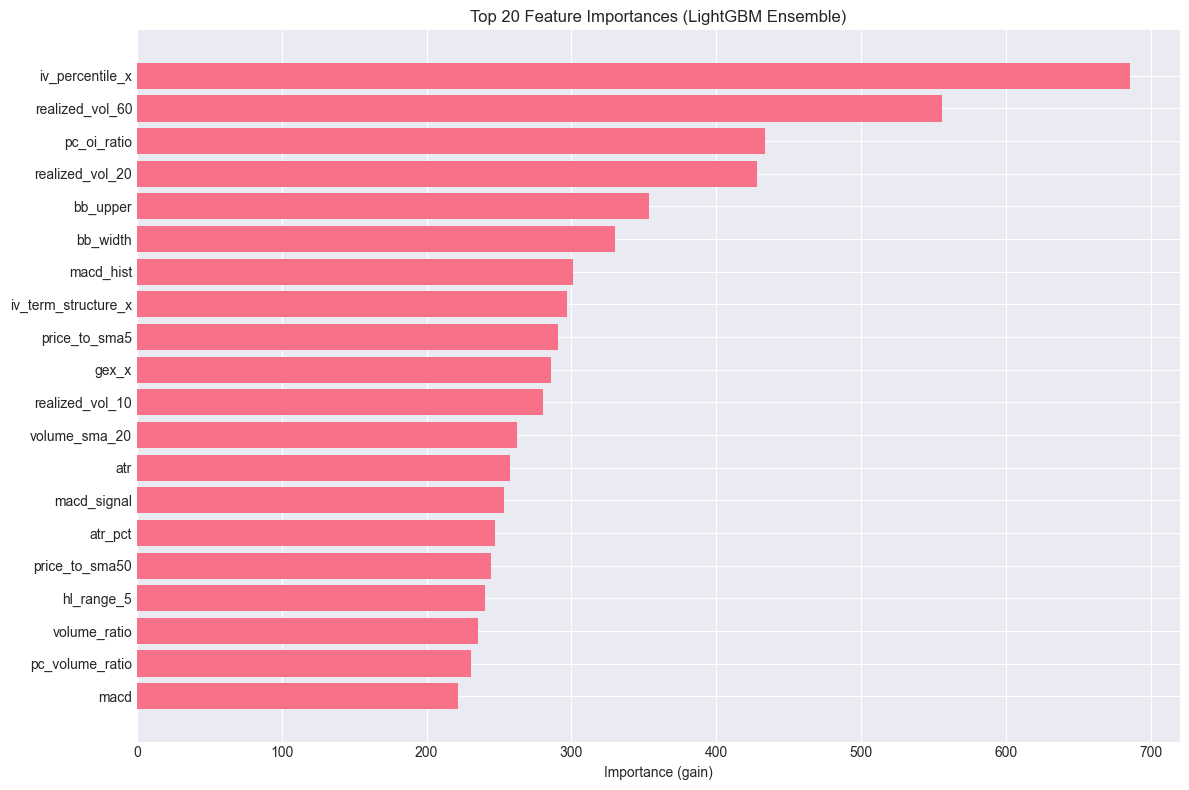

In [41]:
print("✅ Feature Importance Analysis (Cross-Validated Ensemble)...")

# ============================================================
# ✅ 1. Collect importance from each LightGBM fold
# ============================================================
all_importances = np.array([
    model.feature_importance(importance_type='gain')
    for model in fold_models
])

# Average importance across folds
avg_importance = all_importances.mean(axis=0)

# ============================================================
# ✅ 2. Match feature names with training features
# ============================================================
feature_importance = pd.DataFrame({
    "feature": training_feature_cols,
    "importance": avg_importance
}).sort_values("importance", ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# ============================================================
# ✅ 3. Plot Top 20 Feature Importance
# ============================================================
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(top_features["feature"], top_features["importance"])
plt.xlabel("Importance (gain)")
plt.title("Top 20 Feature Importances (LightGBM Ensemble)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


<a id="trading-logic"></a>
## 6. Trading Logic

Implement trading strategy:
- Take long position when predicted probability > 60%
- Size trades using volatility targeting (10% annualized portfolio vol)
- Hold for 5 days or exit if signal weakens


In [42]:
# ============================================================
# ✅ FINAL CLEAN FEATURE PREP BLOCK (USE THIS)
# ============================================================

print("✅ Preparing feature set...")

# ---------------------------------------------------------
# 1. Convert 'nearest_expiry' to numeric days-to-expiry
#    (timezone-safe conversion)
# ---------------------------------------------------------
if "nearest_expiry" in ohlcv.columns:
    idx = pd.to_datetime(ohlcv.index).tz_localize(None)
    exp = ohlcv["nearest_expiry"].dt.tz_localize(None)
    ohlcv["days_to_expiry"] = (exp - idx).dt.days
else:
    ohlcv["days_to_expiry"] = np.nan


# ---------------------------------------------------------
# 2. Columns to EXCLUDE from modeling
# ---------------------------------------------------------
exclude_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'dividends', 'stock splits',
    'returns', 'log_returns',
    'forward_return', 'forward_realized_vol',
    'vol_adjusted_return',
    'label', 'label_severity',
    'nearest_expiry'
]


# ---------------------------------------------------------
# 3. Build initial candidate feature list
# ---------------------------------------------------------
feature_cols = [c for c in ohlcv.columns if c not in exclude_cols]


# ---------------------------------------------------------
# 4. Drop feature columns with too many NaNs
# ---------------------------------------------------------
feature_cols = [
    c for c in feature_cols
    if ohlcv[c].notna().mean() > 0.05    # keep col only if >= 5% non-NaN
]


# ---------------------------------------------------------
# 5. Identify feature categories for logging
# ---------------------------------------------------------
tech_features = [c for c in feature_cols if any(x in c for x in [
    'rsi', 'bb_', 'momentum', 'sma', 'ema', 'macd',
    'atr', 'realized_vol', 'volume', 'hl_range', 'body'
])]

options_features = [c for c in feature_cols if any(x in c for x in [
    'iv', 'pcr', 'gex', 'vix', 'days_to_expiry'
])]

print(f"✅ Total features selected: {len(feature_cols)}")
print(f"   • Technical features: {len(tech_features)}")
print(f"   • Options features:   {len(options_features)}")


# ---------------------------------------------------------
# 6. Prepare final X and y
# ---------------------------------------------------------
X = ohlcv[feature_cols].ffill().fillna(0)   # forward fill then replace any leftover NaN
y = ohlcv["label"]


# ---------------------------------------------------------
# 7. Remove rows where any feature is NaN
# ---------------------------------------------------------
valid_mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[valid_mask]
y = y[valid_mask]


# ---------------------------------------------------------
# ✅ 8. SAVE THE TRAINING FEATURE LIST (CRITICAL!)
# ---------------------------------------------------------
training_feature_cols = feature_cols.copy()
print(f"✅ Saved training feature list: {len(training_feature_cols)} columns")


# ---------------------------------------------------------
# 9. Log shapes
# ---------------------------------------------------------
print("\n✅ Final dataset shapes:")
print(f"   X = {X.shape}")
print(f"   y = {y.shape}")
print("✅ Label distribution:", y.value_counts().to_dict())
print(f"✅ Positive class ratio: {y.mean():.3f}")


✅ Preparing feature set...
✅ Total features selected: 65
   • Technical features: 40
   • Options features:   17
✅ Saved training feature list: 65 columns

✅ Final dataset shapes:
   X = (2721, 65)
   y = (2721,)
✅ Label distribution: {1: 1679, 0: 1042}
✅ Positive class ratio: 0.617


<a id="backtesting"></a>
## 7. Backtesting with Benchmarks

Compare strategy performance against:
1. Buy & Hold
2. MA Crossover
3. Logistic Regression Baseline
4. Skew-only Strategy
5. Gamma-only Strategy


In [34]:
# ============================================================
# ✅ BENCHMARK STRATEGIES (REWRITTEN & CLEAN)
# ============================================================

def buy_and_hold(data, initial_value=100000):
    """Buy & Hold strategy on SPY"""
    returns = data["close"].pct_change().fillna(0)
    portfolio = initial_value * (1 + returns).cumprod()
    return portfolio


def ma_crossover_strategy(data, short_window=50, long_window=200, initial_value=100000):
    """Moving Average Crossover Strategy (long-only)"""

    short_ma = data["close"].rolling(short_window).mean()
    long_ma = data["close"].rolling(long_window).mean()

    # Long when short MA > long MA
    signals = (short_ma > long_ma).astype(int)

    # Shift signals to avoid lookahead bias
    daily_r = data["close"].pct_change().fillna(0)
    strategy_r = daily_r * signals.shift(1).fillna(0)

    portfolio = initial_value * (1 + strategy_r).cumprod()
    return portfolio, signals


def logistic_regression_baseline(X_train, y_train, X_test, data_test):
    """Baseline logistic regression using same threshold logic as ML"""

    # Normalize features
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # Fit model
    lr = LogisticRegression(max_iter=2000)
    lr.fit(X_train_s, y_train)

    # Predict probability of positive outcome
    pred_prob = lr.predict_proba(X_test_s)[:, 1]

    # Binary signal
    signals = (pred_prob >= SIGNAL_THRESHOLD).astype(int)

    # Compute daily returns
    daily_r = data_test["close"].pct_change().fillna(0)
    strategy_r = daily_r * pd.Series(signals, index=data_test.index).shift(1).fillna(0)

    portfolio = 100000 * (1 + strategy_r).cumprod()
    return portfolio, pred_prob


def skew_only_strategy(data, initial_value=100000):
    """Simple strategy based only on IV skew (long when puts expensive)"""

    # Auto-detect correct skew column
    skew_col = next((c for c in data.columns if "iv_skew" in c), None)
    if skew_col is None:
        return pd.Series(initial_value, index=data.index)

    signals = (data[skew_col] < 0).astype(int)
    daily_r = data["close"].pct_change().fillna(0)
    strategy_r = daily_r * signals.shift(1).fillna(0)

    portfolio = initial_value * (1 + strategy_r).cumprod()
    return portfolio


def gamma_only_strategy(data, initial_value=100000):
    """Long when gamma exposure positive (market stable)"""

    # Auto-detect correct GEX column
    gex_col = next((c for c in data.columns if "gex" in c), None)
    if gex_col is None:
        return pd.Series(initial_value, index=data.index)

    signals = (data[gex_col] > 0).astype(int)
    daily_r = data["close"].pct_change().fillna(0)
    strategy_r = daily_r * signals.shift(1).fillna(0)

    portfolio = initial_value * (1 + strategy_r).cumprod()
    return portfolio


# ============================================================
# ✅ RUN ALL BENCHMARKS
# ============================================================

print("Running benchmark strategies...")

# Buy & Hold
bh_returns = buy_and_hold(backtest_data)
print("✔ Buy & Hold")

# MA Crossover
ma_portfolio, ma_signals = ma_crossover_strategy(backtest_data)
print("✔ MA Crossover")

# Logistic Regression (train → test only)
test_idx = X_test.index
lr_portfolio_test, lr_preds_test = logistic_regression_baseline(
    X_train, y_train, X_test, backtest_data.loc[test_idx]
)

# Extend LR results to full period
lr_portfolio = pd.Series(100000.0, index=backtest_data.index)
lr_portfolio.loc[test_idx] = lr_portfolio_test
print("✔ Logistic Regression Baseline")

# Skew-only
skew_portfolio = skew_only_strategy(backtest_data)
print("✔ Skew-only")

# Gamma-only
gamma_portfolio = gamma_only_strategy(backtest_data)
print("✔ Gamma-only")

print("\n✅ All benchmark strategies completed!")


Running benchmark strategies...
✔ Buy & Hold
✔ MA Crossover
✔ Logistic Regression Baseline
✔ Skew-only
✔ Gamma-only

✅ All benchmark strategies completed!


<a id="performance-analysis"></a>
## 8. Performance Analysis

Calculate performance metrics:
- Sharpe Ratio
- Maximum Drawdown
- Win Rate
- Average Return per Trade
- Cumulative Returns


In [45]:
# ============================================================
# ✅ 1. GENERATE PREDICTIONS FOR THE FULL DATASET
# ============================================================

print("Generating predictions for backtesting...")

# Ensure prediction uses ONLY training features
X_pred = ohlcv.loc[X.index, training_feature_cols].ffill().fillna(0)

full_predictions = np.mean([
    model.predict(X_pred)
    for model in fold_models      # ✅ FIXED: use fold_models, not lgbm_models
], axis=0)

# Attach predictions to backtest data
backtest_data = ohlcv.loc[X.index].copy()
backtest_data["predictions"] = full_predictions


# ============================================================
# ✅ 2. RUN THE ML STRATEGY (V2 BACKTEST)
# ============================================================

print("Running V2 backtest...")

strategy_results_v2 = backtest_strategy_v2(
    backtest_data,
    full_predictions,
    threshold=SIGNAL_THRESHOLD,
    vol_target=VOL_TARGET
)

final_value = strategy_results_v2["portfolio_value"].iloc[-1]
total_return = (final_value / 100000 - 1) * 100

print("\n================ BACKTEST RESULTS (V2) ================")
print(f"Final Portfolio Value: ${final_value:,.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Total Trades: {strategy_results_v2['signals'].sum()}")
print("======================================================\n")


# ============================================================
# ✅ 3. BENCHMARK STRATEGIES
# ============================================================

print("Running benchmark strategies...\n")

# BUY & HOLD
bh_returns = buy_and_hold(backtest_data)

# MA CROSSOVER
ma_portfolio, ma_signals = ma_crossover_strategy(backtest_data)

# LOGISTIC REGRESSION (train-test split baseline)
test_idx = X_test.index
lr_portfolio_test, lr_preds_test = logistic_regression_baseline(
    X_train, y_train, X_test, backtest_data.loc[test_idx]
)

lr_portfolio = pd.Series(100000.0, index=backtest_data.index)
lr_portfolio.loc[test_idx] = lr_portfolio_test

# SKEW-ONLY STRATEGY
skew_portfolio = skew_only_strategy(backtest_data)

# GAMMA-ONLY STRATEGY
gamma_portfolio = gamma_only_strategy(backtest_data)

print("✅ Benchmarks complete!\n")


# ============================================================
# ✅ 4. PERFORMANCE METRICS V2
# ============================================================

def calculate_performance_metrics(portfolio_value):
    """Compute standardized performance metrics."""
    
    daily_r = portfolio_value.pct_change().fillna(0)

    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0] - 1) * 100
    n_days = len(portfolio_value)
    annual_return = ((portfolio_value.iloc[-1] / portfolio_value.iloc[0]) ** (252 / n_days) - 1) * 100

    annual_vol = daily_r.std() * np.sqrt(252) * 100
    sharpe = (annual_return / annual_vol) if annual_vol > 0 else 0

    downside = daily_r[daily_r < 0].std() * np.sqrt(252) * 100
    sortino = (annual_return / downside) if downside > 0 else 0

    running_max = portfolio_value.cummax()
    drawdown = (portfolio_value - running_max) / running_max
    max_dd = drawdown.min() * 100

    return {
        "Total Return (%)": total_return,
        "Annualized Return (%)": annual_return,
        "Annualized Volatility (%)": annual_vol,
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Max Drawdown (%)": max_dd,
    }


print("✅ Calculating performance metrics...\n")

results_dict = {
    "ML Strategy (LGBM V2)": strategy_results_v2["portfolio_value"],
    "Buy & Hold": bh_returns,
    "MA Crossover": ma_portfolio,
    "Logistic Regression": lr_portfolio,
    "Skew-only": skew_portfolio,
    "Gamma-only": gamma_portfolio
}

metrics_table = {name: calculate_performance_metrics(port)
                 for name, port in results_dict.items()}

comparison = pd.DataFrame(metrics_table).T.round(2)


# ============================================================
# ✅ 5. PRINT METRICS TABLE
# ============================================================

print("\n" + "="*90)
print("✅ PERFORMANCE COMPARISON")
print("="*90)
print(comparison)
print("\n✅ All analytics complete!")


Generating predictions for backtesting...
Running V2 backtest...

================ BACKTEST RESULTS (V2) ================
Final Portfolio Value: $115,550.40
Total Return: 15.55%
Total Trades: 1366

Running benchmark strategies...

✅ Benchmarks complete!

✅ Calculating performance metrics...


✅ PERFORMANCE COMPARISON
                       Total Return (%)  Annualized Return (%)  \
ML Strategy (LGBM V2)             15.55                   1.35   
Buy & Hold                       297.74                  13.64   
MA Crossover                     138.74                   8.39   
Logistic Regression                9.89                   0.88   
Skew-only                        194.01                  10.50   
Gamma-only                       222.64                  11.46   

                       Annualized Volatility (%)  Sharpe Ratio  Sortino Ratio  \
ML Strategy (LGBM V2)                       0.48          2.83           3.03   
Buy & Hold                                 17.85        

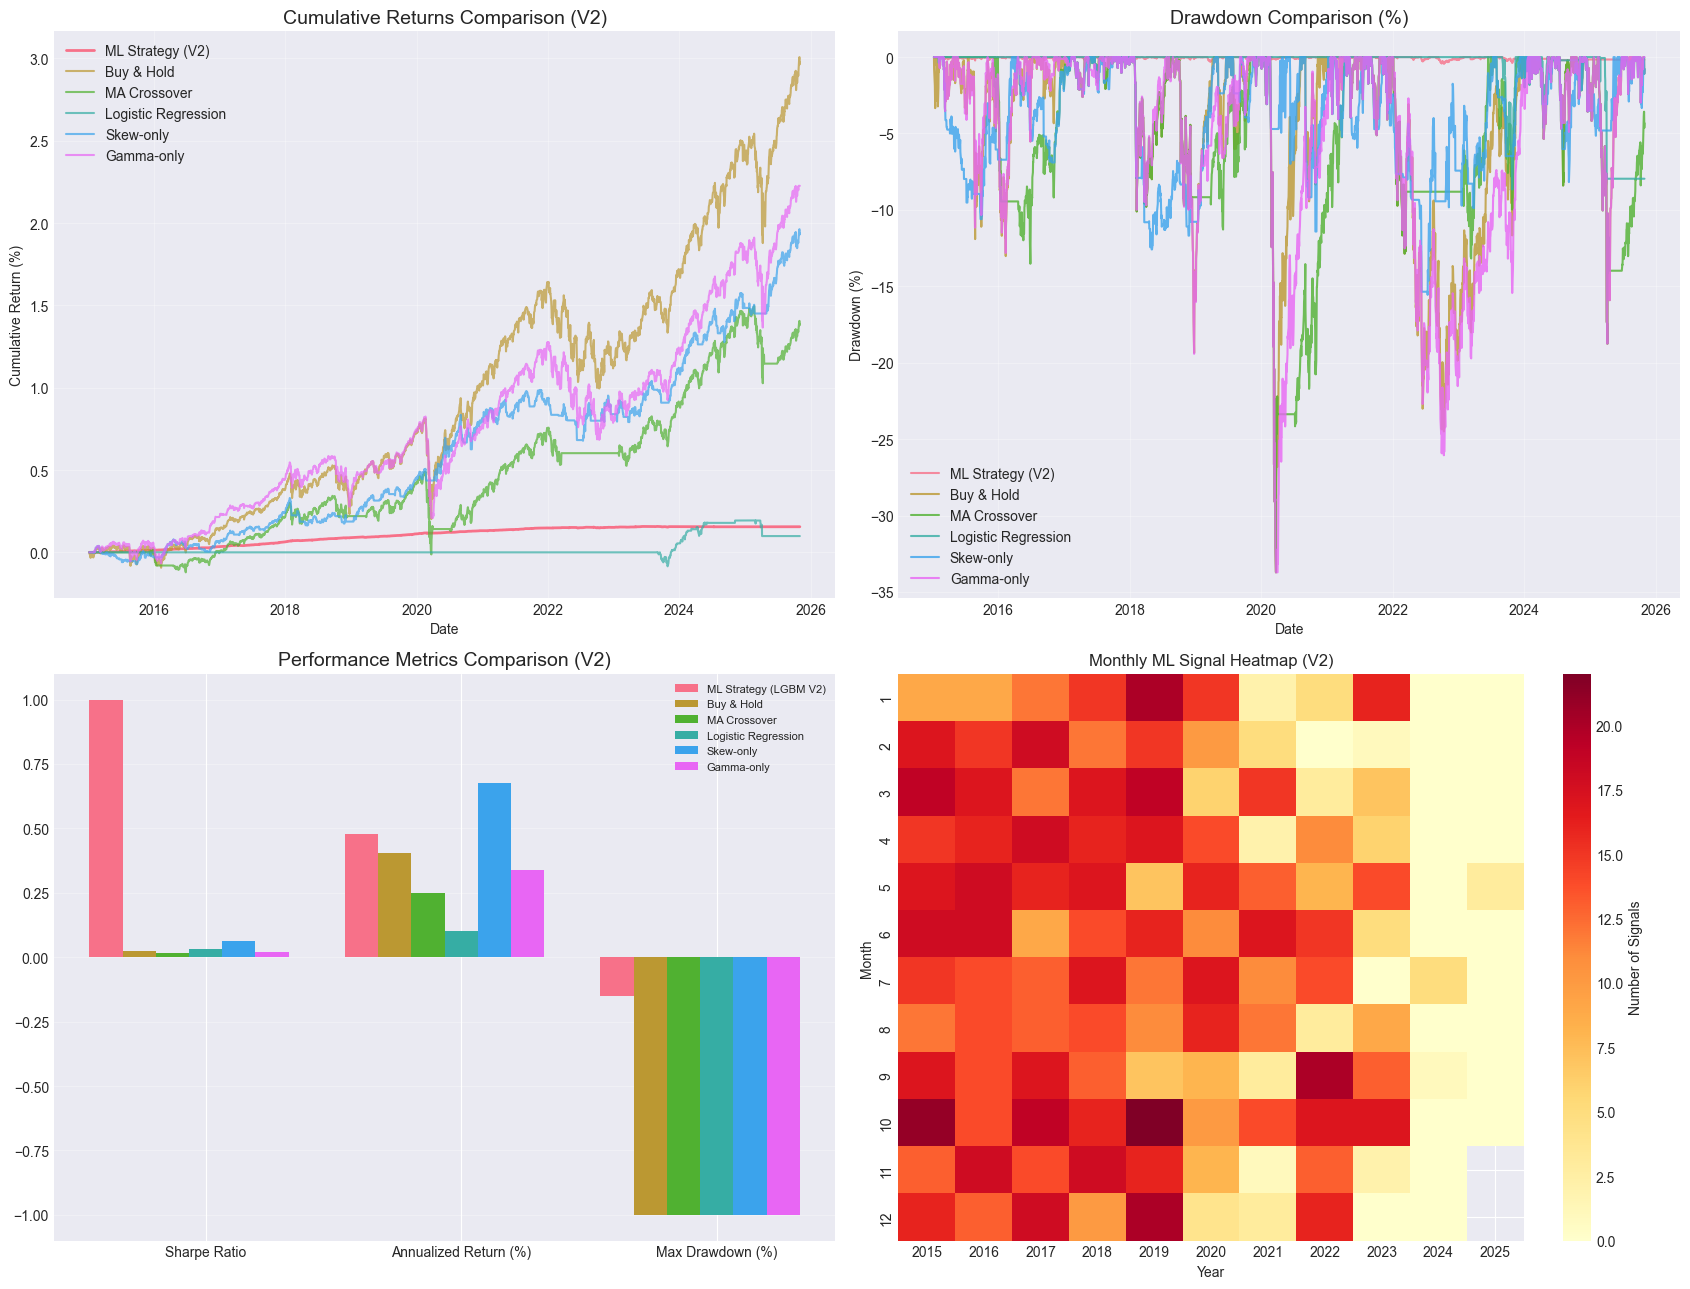

In [47]:
# ============================================================
# ✅ VISUALIZATIONS FOR V2 STRATEGY & BENCHMARKS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(17, 13))

# ============================================================
# ✅ 1. CUMULATIVE RETURNS COMPARISON
# ============================================================
ax1 = axes[0, 0]

ax1.plot(strategy_results_v2.index, 
         strategy_results_v2['portfolio_value'] / 100000 - 1,
         label='ML Strategy (V2)', linewidth=2)

ax1.plot(bh_returns.index, bh_returns / 100000 - 1,
         label='Buy & Hold', alpha=0.7)

ax1.plot(ma_portfolio.index, ma_portfolio / 100000 - 1,
         label='MA Crossover', alpha=0.7)

ax1.plot(lr_portfolio.index, lr_portfolio / 100000 - 1,
         label='Logistic Regression', alpha=0.7)

ax1.plot(skew_portfolio.index, skew_portfolio / 100000 - 1,
         label='Skew-only', alpha=0.7)

ax1.plot(gamma_portfolio.index, gamma_portfolio / 100000 - 1,
         label='Gamma-only', alpha=0.7)

ax1.set_title("Cumulative Returns Comparison (V2)", fontsize=14)
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative Return (%)")
ax1.legend()
ax1.grid(True, alpha=0.3)


# ============================================================
# ✅ 2. DRAWDOWN COMPARISON
# ============================================================
ax2 = axes[0, 1]

compare_portfolios = {
    "ML Strategy (V2)": strategy_results_v2['portfolio_value'],
    "Buy & Hold": bh_returns,
    "MA Crossover": ma_portfolio,
    "Logistic Regression": lr_portfolio,
    "Skew-only": skew_portfolio,
    "Gamma-only": gamma_portfolio
}

for name, port in compare_portfolios.items():
    running_max = port.expanding().max()
    drawdown = (port - running_max) / running_max * 100
    ax2.plot(drawdown.index, drawdown, label=name, alpha=0.8)

ax2.set_title("Drawdown Comparison (%)", fontsize=14)
ax2.set_xlabel("Date")
ax2.set_ylabel("Drawdown (%)")
ax2.legend()
ax2.grid(True, alpha=0.3)


# ============================================================
# ✅ 3. PERFORMANCE METRICS BAR CHART
# ============================================================
ax3 = axes[1, 0]

metrics_to_plot = ["Sharpe Ratio", "Annualized Return (%)", "Max Drawdown (%)"]
strategies = list(comparison.index)

x = np.arange(len(metrics_to_plot))
width = 0.13

for i, strat in enumerate(strategies):
    values = [comparison.loc[strat, m] for m in metrics_to_plot]

    # Normalize
    max_val = max(abs(v) for v in values)
    normalized = [v / max_val if max_val != 0 else 0 for v in values]

    ax3.bar(x + i * width, normalized, width, label=strat)

ax3.set_xticks(x + width * (len(strategies)/2))
ax3.set_xticklabels(metrics_to_plot)
ax3.set_title("Performance Metrics Comparison (V2)", fontsize=14)
ax3.legend(fontsize=8)
ax3.grid(True, axis='y', alpha=0.3)


# ============================================================
# ✅ 4. SIGNAL HEATMAP
# ============================================================
ax4 = axes[1, 1]

signal_data = strategy_results_v2[['signals', 'predictions']].copy()
signal_data["year"] = signal_data.index.year
signal_data["month"] = signal_data.index.month

heatmap_data = signal_data.pivot_table(
    values='signals',
    index='month',
    columns='year',
    aggfunc='sum'
)

sns.heatmap(
    heatmap_data,
    cmap='YlOrRd',
    ax=ax4,
    cbar_kws={'label': 'Number of Signals'}
)

ax4.set_title("Monthly ML Signal Heatmap (V2)")
ax4.set_xlabel("Year")
ax4.set_ylabel("Month")

plt.tight_layout()
plt.show()


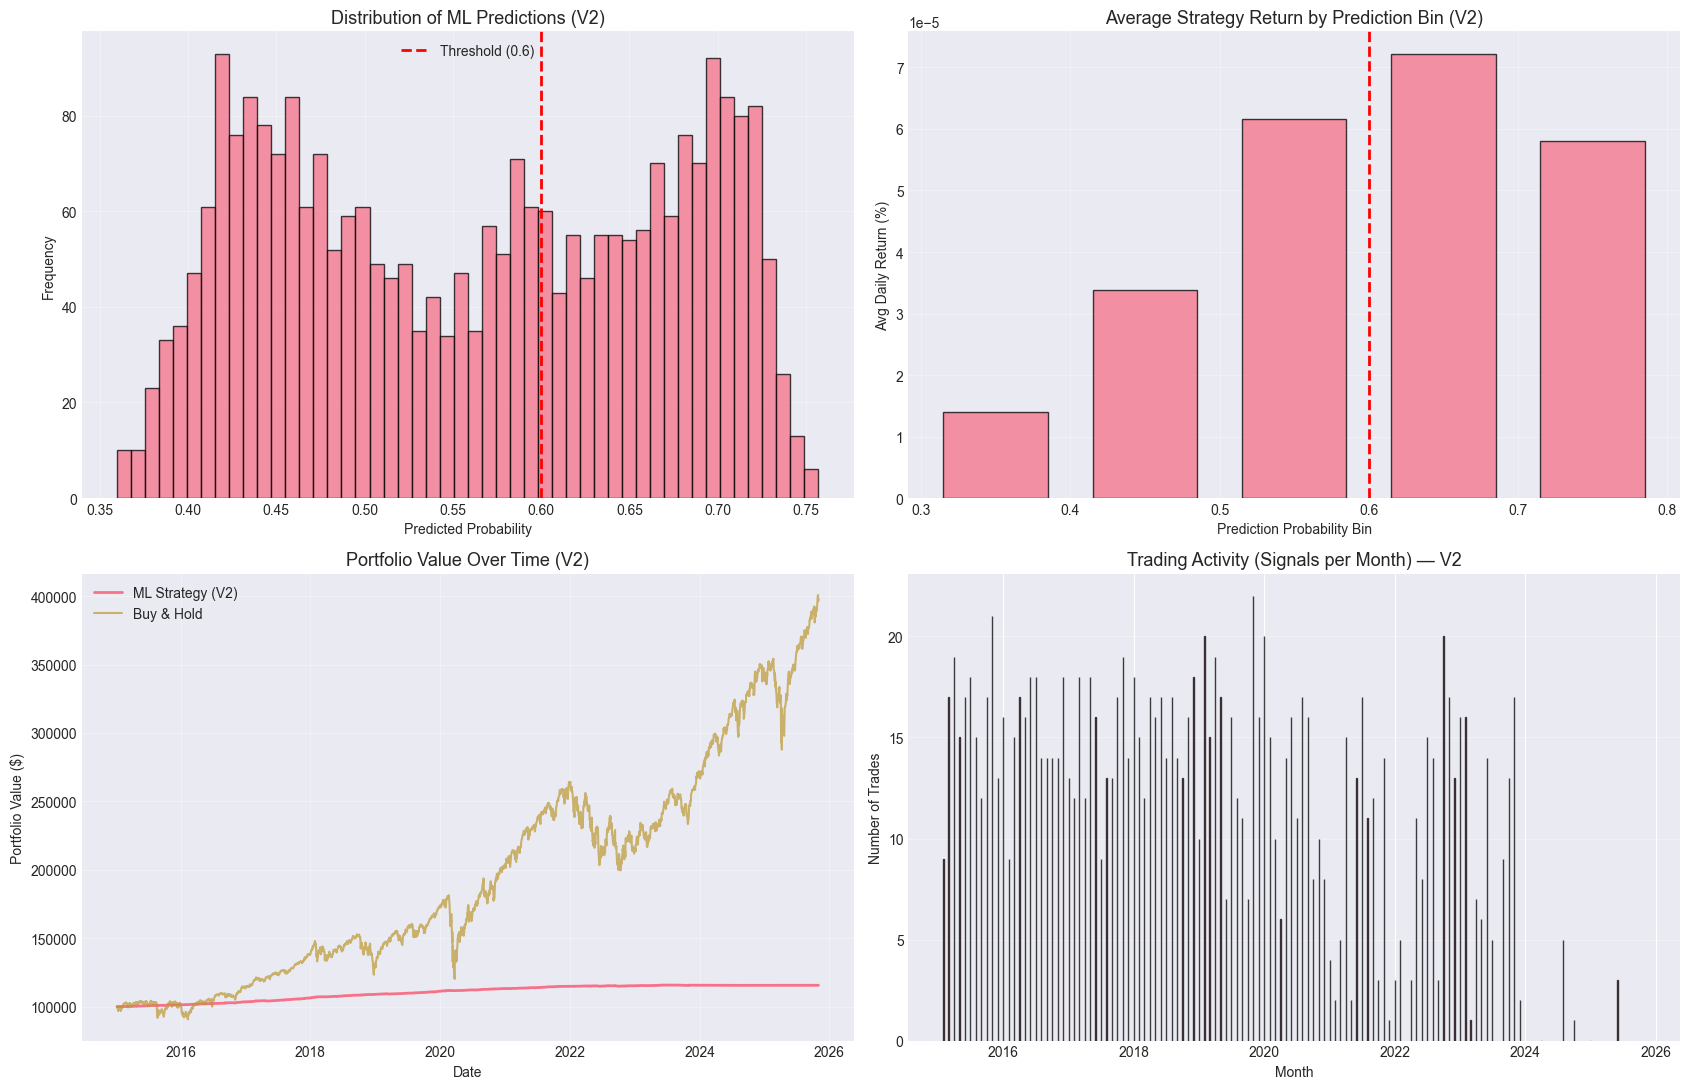


✅ STRATEGY SUMMARY (V2)
Total Trades: 1366
Average Trades per Month: 10.5
Max Trades in a Month: 22
Signal Days: 1366
Signal Frequency: 50.20%

Final Portfolio Value (V2): $115,550.40
Buy & Hold Final Value:     $397,737.20
Excess Return over B&H:     $-282,186.80


In [48]:
# ============================================================
# ✅ ADDITIONAL ANALYSIS (V2 STRATEGY ONLY)
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(17, 11))

# ============================================================
# ✅ 1. Prediction Distribution
# ============================================================
ax1 = axes[0, 0]
ax1.hist(full_predictions, bins=50, alpha=0.75, edgecolor="black")
ax1.axvline(SIGNAL_THRESHOLD, color="red", linestyle="--", linewidth=2,
            label=f"Threshold ({SIGNAL_THRESHOLD})")

ax1.set_title("Distribution of ML Predictions (V2)", fontsize=13)
ax1.set_xlabel("Predicted Probability")
ax1.set_ylabel("Frequency")
ax1.grid(True, alpha=0.3)
ax1.legend()


# ============================================================
# ✅ 2. Returns by Prediction Strength (Using V2 Returns)
# ============================================================
ax2 = axes[0, 1]

bins = np.linspace(0, 1, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_labels = pd.cut(full_predictions, bins=bins, labels=bin_centers)

# We use V2 realized PnL (strategy_returns is implicit in portfolio value)
v2_daily_returns = strategy_results_v2["portfolio_value"].pct_change().fillna(0)

returns_by_bin = v2_daily_returns.groupby(bin_labels).mean()

ax2.bar(bin_centers, returns_by_bin.values, width=0.07, alpha=0.75, edgecolor="black")
ax2.axhline(0, color="black", linestyle="-", linewidth=0.5)
ax2.axvline(SIGNAL_THRESHOLD, color="red", linestyle="--", linewidth=2)

ax2.set_title("Average Strategy Return by Prediction Bin (V2)", fontsize=13)
ax2.set_xlabel("Prediction Probability Bin")
ax2.set_ylabel("Avg Daily Return (%)")
ax2.grid(True, alpha=0.3)


# ============================================================
# ✅ 3. Portfolio Value Comparison (V2 vs Benchmarks)
# ============================================================
ax3 = axes[1, 0]

ax3.plot(strategy_results_v2.index, strategy_results_v2["portfolio_value"],
         label="ML Strategy (V2)", linewidth=2)

ax3.plot(bh_returns.index, bh_returns, label="Buy & Hold", alpha=0.7)

ax3.set_title("Portfolio Value Over Time (V2)", fontsize=13)
ax3.set_xlabel("Date")
ax3.set_ylabel("Portfolio Value ($)")
ax3.legend()
ax3.grid(True, alpha=0.3)


# ============================================================
# ✅ 4. Trading Activity (V2)
# ============================================================
ax4 = axes[1, 1]

trades_per_month = strategy_results_v2["signals"].resample("M").sum()

ax4.bar(trades_per_month.index, trades_per_month.values,
        alpha=0.75, edgecolor="black")

ax4.set_title("Trading Activity (Signals per Month) — V2", fontsize=13)
ax4.set_xlabel("Month")
ax4.set_ylabel("Number of Trades")
ax4.grid(True, axis="y", alpha=0.3)


plt.tight_layout()
plt.show()


# ============================================================
# ✅ SUMMARY STATISTICS (V2)
# ============================================================

print("\n" + "="*90)
print("✅ STRATEGY SUMMARY (V2)")
print("="*90)

print(f"Total Trades: {strategy_results_v2['signals'].sum()}")
print(f"Average Trades per Month: {trades_per_month.mean():.1f}")
print(f"Max Trades in a Month: {trades_per_month.max()}")
print(f"Signal Days: {(strategy_results_v2['signals'] > 0).sum()}")
print(f"Signal Frequency: {(strategy_results_v2['signals'] > 0).sum() / len(strategy_results_v2) * 100:.2f}%")

print(f"\nFinal Portfolio Value (V2): ${strategy_results_v2['portfolio_value'].iloc[-1]:,.2f}")
print(f"Buy & Hold Final Value:     ${bh_returns.iloc[-1]:,.2f}")
print(f"Excess Return over B&H:     ${strategy_results_v2['portfolio_value'].iloc[-1] - bh_returns.iloc[-1]:,.2f}")

print("="*90)
